In [1]:
# =============================================================================
# Title   : Fuzzy Logic Portfolio — Engineering & Control (3 Examples)
# Course  : Models and Methods of Intelligent Systems
# Topic   : Fuzzy Inference Systems (Mamdani) for Control Applications
# Author  : Dr.-Ing. Cesar Hernando Valencia Niño
# Date    : 2026-01-27
#
# Notebook Contents
# -----------------
# 1) Water Tank Level Control (error, error_rate -> valve)
# 2) HVAC Cooling Control (temp_error, humidity -> cooling)
# 3) DC Motor Control (speed_error, load -> voltage)
# =============================================================================
# =========================
# Install & Imports
# =========================
!pip -q install scikit-fuzzy ipywidgets

import numpy as np
import matplotlib.pyplot as plt

import skfuzzy as fuzz
from skfuzzy import control as ctrl

from ipywidgets import interact, FloatSlider, HTML
from IPython.display import display

# Enable widgets in Colab
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except Exception:
    pass

print("Setup complete.")
# =========================
# Helper Utilities
# =========================
def plot_mfs(variable, title_suffix=""):
    """Plot membership functions of a scikit-fuzzy Antecedent/Consequent."""
    plt.figure()
    for term_name, term_obj in variable.terms.items():
        plt.plot(variable.universe, term_obj.mf, label=term_name)
    plt.title(f"Membership Functions — {variable.label} {title_suffix}".strip())
    plt.xlabel(variable.label)
    plt.ylabel("Membership degree")
    plt.ylim(-0.05, 1.05)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def report_system(title, antecedents, consequents, rules):
    """
    Pretty report: variables/universes, fuzzy sets (terms), and rule base.
    """
    print("\n" + "="*80)
    print(title)
    print("="*80)

    def _describe_var(v):
        u = v.universe
        print(f"\nVariable: {v.label}")
        print(f"  Universe: [{float(u.min()):.4f}, {float(u.max()):.4f}]  |  Points: {len(u)}")
        print("  Fuzzy sets (terms):")
        for tname in v.terms.keys():
            print(f"    - {tname}")

    print("\n--- Antecedents (Inputs) ---")
    for a in antecedents:
        _describe_var(a)

    print("\n--- Consequents (Outputs) ---")
    for c in consequents:
        _describe_var(c)

    print("\n--- Rule Base ---")
    for i, r in enumerate(rules, 1):
        # str(r) prints a clean IF-THEN representation in scikit-fuzzy
        print(f"{i:02d}. {str(r)}")

def build_dashboard(system, inputs_spec, output_name, title):
    """
    Interactive dashboard: sliders -> compute -> print defuzzified output.
    inputs_spec: list of (name, min, max, step, initial)
    """
    sim = ctrl.ControlSystemSimulation(system)

    slider_kwargs = {}
    for (name, vmin, vmax, step, v0) in inputs_spec:
        slider_kwargs[name] = FloatSlider(
            value=v0, min=vmin, max=vmax, step=step,
            description=name, continuous_update=False
        )

    display(HTML(f"<h3 style='margin:6px 0'>{title}</h3>"))

    def _run(**kwargs):
        for k, v in kwargs.items():
            sim.input[k] = float(v)
        sim.compute()
        y = float(sim.output[output_name])
        print(f"{output_name} (defuzzified) = {y:.6f}")
        return y

    interact(_run, **slider_kwargs)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.7 MB/s eta 0:00:00
Setup complete.



Example 1 — Water Tank Level Control

--- Antecedents (Inputs) ---

Variable: error
  Universe: [-1.0000, 1.0000]  |  Points: 201
  Fuzzy sets (terms):
    - neg
    - zero
    - pos

Variable: error_rate
  Universe: [-1.0000, 1.0000]  |  Points: 201
  Fuzzy sets (terms):
    - neg
    - zero
    - pos

--- Consequents (Outputs) ---

Variable: valve
  Universe: [0.0000, 100.0000]  |  Points: 201
  Fuzzy sets (terms):
    - close
    - mid
    - open

--- Rule Base ---
01. IF error[pos] AND error_rate[pos] THEN valve[open]
	AND aggregation function : fmin
	OR aggregation function  : fmax
02. IF error[pos] AND error_rate[zero] THEN valve[open]
	AND aggregation function : fmin
	OR aggregation function  : fmax
03. IF error[pos] AND error_rate[neg] THEN valve[mid]
	AND aggregation function : fmin
	OR aggregation function  : fmax
04. IF error[zero] THEN valve[mid]
	AND aggregation function : fmin
	OR aggregation function  : fmax
05. IF error[neg] AND error_rate[neg] THEN valve[close]
	AND a

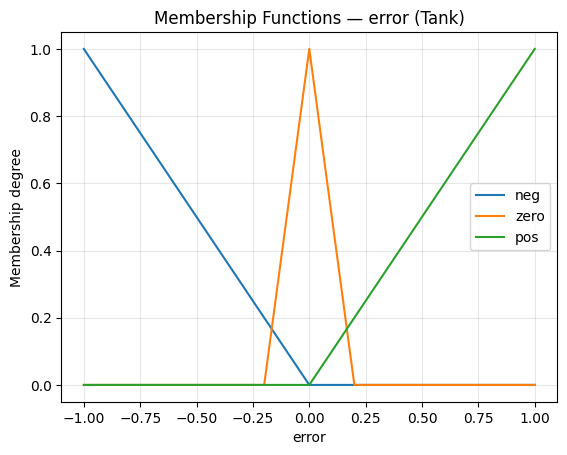

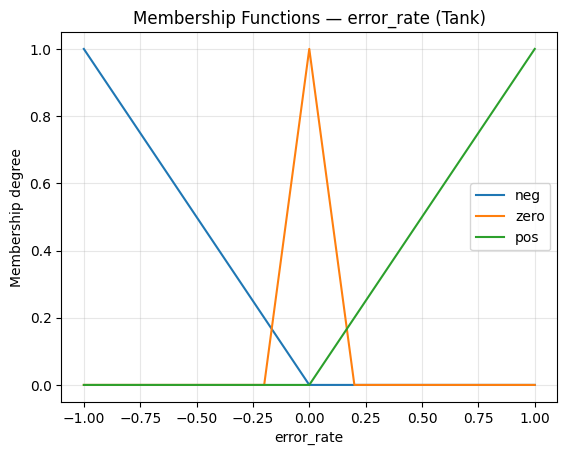

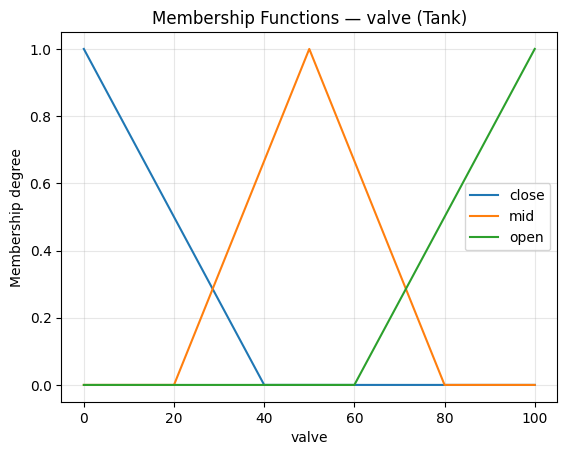

HTML(value="<h3 style='margin:6px 0'>Example 1 — Water Tank (error, error_rate → valve)</h3>")

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='error', max=1.0, min=-1.0, …

In [2]:
# =========================
# [CELL 3] Example 1 — Water Tank Level Control
# =========================
error = ctrl.Antecedent(np.linspace(-1, 1, 201), 'error')           # setpoint - level
error_rate = ctrl.Antecedent(np.linspace(-1, 1, 201), 'error_rate') # derivative
valve = ctrl.Consequent(np.linspace(0, 100, 201), 'valve')          # %

# Membership functions
error['neg']  = fuzz.trimf(error.universe, [-1, -1, 0])
error['zero'] = fuzz.trimf(error.universe, [-0.2, 0, 0.2])
error['pos']  = fuzz.trimf(error.universe, [0, 1, 1])

error_rate['neg']  = fuzz.trimf(error_rate.universe, [-1, -1, 0])
error_rate['zero'] = fuzz.trimf(error_rate.universe, [-0.2, 0, 0.2])
error_rate['pos']  = fuzz.trimf(error_rate.universe, [0, 1, 1])

valve['close'] = fuzz.trimf(valve.universe, [0, 0, 40])
valve['mid']   = fuzz.trimf(valve.universe, [20, 50, 80])
valve['open']  = fuzz.trimf(valve.universe, [60, 100, 100])

# Rules
rules = [
    ctrl.Rule(error['pos'] & error_rate['pos'], valve['open']),
    ctrl.Rule(error['pos'] & error_rate['zero'], valve['open']),
    ctrl.Rule(error['pos'] & error_rate['neg'], valve['mid']),
    ctrl.Rule(error['zero'], valve['mid']),
    ctrl.Rule(error['neg'] & error_rate['neg'], valve['close']),
    ctrl.Rule(error['neg'] & error_rate['zero'], valve['close']),
    ctrl.Rule(error['neg'] & error_rate['pos'], valve['mid']),
]

system = ctrl.ControlSystem(rules)

report_system(
    title="Example 1 — Water Tank Level Control",
    antecedents=[error, error_rate],
    consequents=[valve],
    rules=rules
)

plot_mfs(error, "(Tank)")
plot_mfs(error_rate, "(Tank)")
plot_mfs(valve, "(Tank)")

build_dashboard(
    system=system,
    inputs_spec=[('error', -1.0, 1.0, 0.01, 0.2), ('error_rate', -1.0, 1.0, 0.01, 0.0)],
    output_name='valve',
    title="Example 1 — Water Tank (error, error_rate → valve)"
)



Example 2 — HVAC Cooling Control

--- Antecedents (Inputs) ---

Variable: temp_error
  Universe: [-5.0000, 5.0000]  |  Points: 201
  Fuzzy sets (terms):
    - cold
    - ok
    - hot

Variable: humidity
  Universe: [0.0000, 100.0000]  |  Points: 201
  Fuzzy sets (terms):
    - low
    - mid
    - high

--- Consequents (Outputs) ---

Variable: cooling
  Universe: [0.0000, 100.0000]  |  Points: 201
  Fuzzy sets (terms):
    - low
    - mid
    - high

--- Rule Base ---
01. IF temp_error[cold] THEN cooling[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
02. IF temp_error[ok] AND humidity[low] THEN cooling[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
03. IF temp_error[ok] AND humidity[mid] THEN cooling[mid]
	AND aggregation function : fmin
	OR aggregation function  : fmax
04. IF temp_error[ok] AND humidity[high] THEN cooling[mid]
	AND aggregation function : fmin
	OR aggregation function  : fmax
05. IF temp_error[hot] AND humidity[low] THEN 

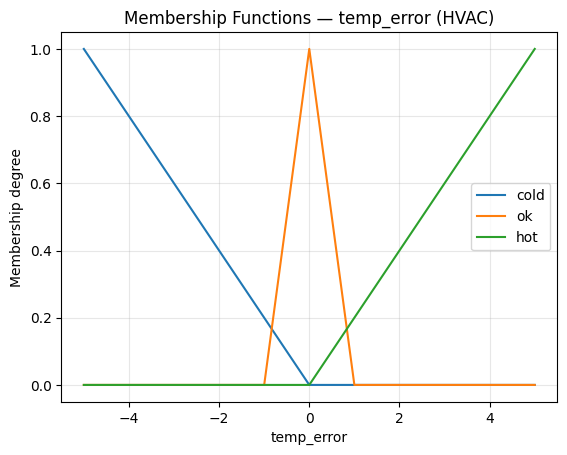

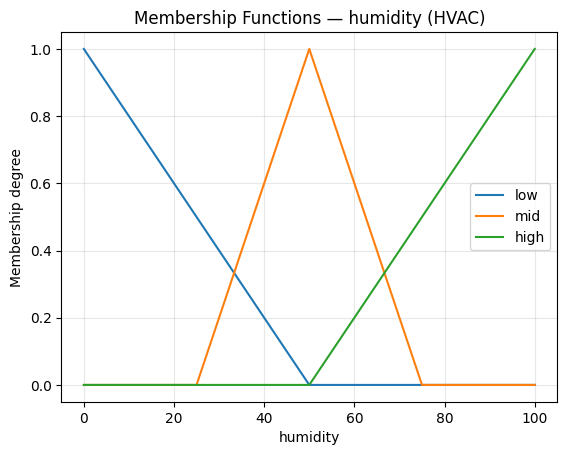

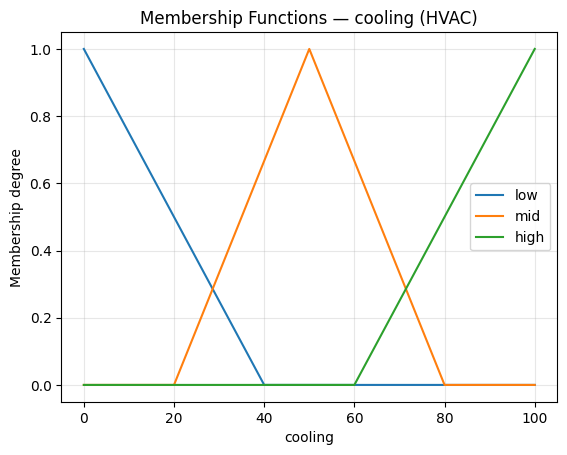

HTML(value="<h3 style='margin:6px 0'>Example 2 — HVAC (temp_error, humidity → cooling)</h3>")

interactive(children=(FloatSlider(value=1.5, continuous_update=False, description='temp_error', max=5.0, min=-…

In [3]:
# =========================
# [CELL 4] Example 2 — HVAC Cooling Control
# =========================
temp_error = ctrl.Antecedent(np.linspace(-5, 5, 201), 'temp_error')  # °C
humidity = ctrl.Antecedent(np.linspace(0, 100, 201), 'humidity')     # %
cooling = ctrl.Consequent(np.linspace(0, 100, 201), 'cooling')       # %

temp_error['cold'] = fuzz.trimf(temp_error.universe, [-5, -5, 0])
temp_error['ok']   = fuzz.trimf(temp_error.universe, [-1, 0, 1])
temp_error['hot']  = fuzz.trimf(temp_error.universe, [0, 5, 5])

humidity['low']  = fuzz.trimf(humidity.universe, [0, 0, 50])
humidity['mid']  = fuzz.trimf(humidity.universe, [25, 50, 75])
humidity['high'] = fuzz.trimf(humidity.universe, [50, 100, 100])

cooling['low']  = fuzz.trimf(cooling.universe, [0, 0, 40])
cooling['mid']  = fuzz.trimf(cooling.universe, [20, 50, 80])
cooling['high'] = fuzz.trimf(cooling.universe, [60, 100, 100])

rules = [
    ctrl.Rule(temp_error['cold'], cooling['low']),
    ctrl.Rule(temp_error['ok'] & humidity['low'], cooling['low']),
    ctrl.Rule(temp_error['ok'] & humidity['mid'], cooling['mid']),
    ctrl.Rule(temp_error['ok'] & humidity['high'], cooling['mid']),
    ctrl.Rule(temp_error['hot'] & humidity['low'], cooling['mid']),
    ctrl.Rule(temp_error['hot'] & humidity['mid'], cooling['high']),
    ctrl.Rule(temp_error['hot'] & humidity['high'], cooling['high']),
]

system = ctrl.ControlSystem(rules)

report_system(
    title="Example 2 — HVAC Cooling Control",
    antecedents=[temp_error, humidity],
    consequents=[cooling],
    rules=rules
)

plot_mfs(temp_error, "(HVAC)")
plot_mfs(humidity, "(HVAC)")
plot_mfs(cooling, "(HVAC)")

build_dashboard(
    system=system,
    inputs_spec=[('temp_error', -5.0, 5.0, 0.1, 1.5), ('humidity', 0.0, 100.0, 1.0, 60.0)],
    output_name='cooling',
    title="Example 2 — HVAC (temp_error, humidity → cooling)"
)



Example 3 — DC Motor Control

--- Antecedents (Inputs) ---

Variable: speed_error
  Universe: [-1.0000, 1.0000]  |  Points: 201
  Fuzzy sets (terms):
    - neg
    - zero
    - pos

Variable: load
  Universe: [0.0000, 1.0000]  |  Points: 201
  Fuzzy sets (terms):
    - low
    - high

--- Consequents (Outputs) ---

Variable: voltage
  Universe: [0.0000, 1.0000]  |  Points: 201
  Fuzzy sets (terms):
    - low
    - mid
    - high

--- Rule Base ---
01. IF speed_error[neg] THEN voltage[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
02. IF speed_error[zero] AND load[low] THEN voltage[mid]
	AND aggregation function : fmin
	OR aggregation function  : fmax
03. IF speed_error[zero] AND load[high] THEN voltage[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax
04. IF speed_error[pos] AND load[low] THEN voltage[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax
05. IF speed_error[pos] AND load[high] THEN voltage[high]
	AND aggre

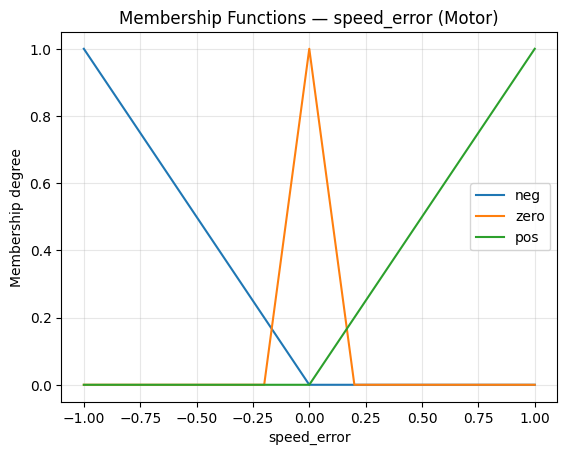

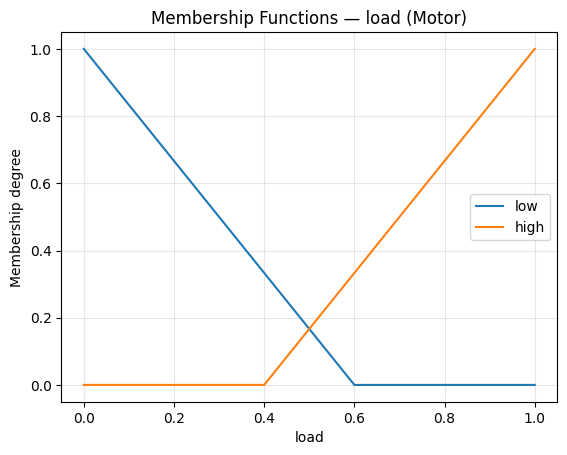

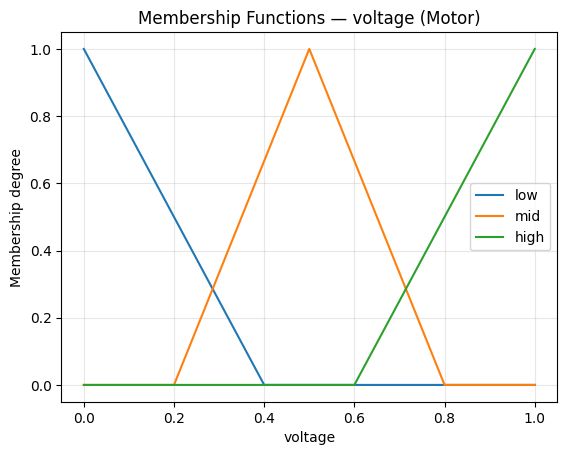

HTML(value="<h3 style='margin:6px 0'>Example 3 — DC Motor (speed_error, load → voltage)</h3>")

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='speed_error', max=1.0, min=…

In [4]:
# =========================
# [CELL 5] Example 3 — DC Motor Control
# =========================
speed_error = ctrl.Antecedent(np.linspace(-1, 1, 201), 'speed_error')
load = ctrl.Antecedent(np.linspace(0, 1, 201), 'load')         # normalized
voltage = ctrl.Consequent(np.linspace(0, 1, 201), 'voltage')   # normalized

speed_error['neg']  = fuzz.trimf(speed_error.universe, [-1, -1, 0])
speed_error['zero'] = fuzz.trimf(speed_error.universe, [-0.2, 0, 0.2])
speed_error['pos']  = fuzz.trimf(speed_error.universe, [0, 1, 1])

load['low']  = fuzz.trimf(load.universe, [0, 0, 0.6])
load['high'] = fuzz.trimf(load.universe, [0.4, 1, 1])

voltage['low']  = fuzz.trimf(voltage.universe, [0, 0, 0.4])
voltage['mid']  = fuzz.trimf(voltage.universe, [0.2, 0.5, 0.8])
voltage['high'] = fuzz.trimf(voltage.universe, [0.6, 1, 1])

rules = [
    ctrl.Rule(speed_error['neg'], voltage['low']),
    ctrl.Rule(speed_error['zero'] & load['low'], voltage['mid']),
    ctrl.Rule(speed_error['zero'] & load['high'], voltage['high']),
    ctrl.Rule(speed_error['pos'] & load['low'], voltage['high']),
    ctrl.Rule(speed_error['pos'] & load['high'], voltage['high']),
]

system = ctrl.ControlSystem(rules)

report_system(
    title="Example 3 — DC Motor Control",
    antecedents=[speed_error, load],
    consequents=[voltage],
    rules=rules
)

plot_mfs(speed_error, "(Motor)")
plot_mfs(load, "(Motor)")
plot_mfs(voltage, "(Motor)")

build_dashboard(
    system=system,
    inputs_spec=[('speed_error', -1.0, 1.0, 0.01, 0.2), ('load', 0.0, 1.0, 0.01, 0.5)],
    output_name='voltage',
    title="Example 3 — DC Motor (speed_error, load → voltage)"
)
